### Importing packages

In [147]:
import pickle
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import statsmodels.api as sm
from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Load data

In [15]:
with open(
    file="../data/coin_px_vol_2022-06-24_to_2025-06-24.pkl", 
    mode="rb"
    ) as f:
    data_dict = pickle.load(f)

coin_prices = pd.concat(
    [
        data_dict[i]["price"] for i in data_dict
    ],
    axis=1
)

coin_prices.columns = [i for i in data_dict]

coin_prices = coin_prices.dropna(
    axis = 1,
    thresh = 0.99 * coin_prices.shape[0]
).ffill(limit=2).replace(np.nan, 0)

print(
    f"Crypto data from {str(coin_prices.index.min().date())} to {str(coin_prices.index.max().date())}"
    )
coin_prices.tail(4)


Crypto data from 2022-06-25 to 2025-06-24


,SOL,BTC,XRP,DOGE,ETH,ADA,BNB,TRX,AAVE,UNI,...,BICO,FIST,GMX,BAND,LRC,RARE,SKL,TWT,HNT,PHB
date,,,,,,,,,,,,,,,,,,,,,
2025-06-21,140.061295,103290.105145,2.120113,0.162332,2403.607721,0.576848,641.466075,0.272483,247.264404,7.073481,...,0.089715,0.321726,14.070058,0.584629,0.075146,0.048383,0.017951,0.722245,2.428924,0.414596
2025-06-22,133.866437,101532.568385,2.044380,0.153080,2277.899190,0.550708,626.568767,0.270289,231.713187,6.388992,...,0.085296,0.437483,13.186598,0.550390,0.071409,0.044991,0.016872,0.684994,2.251220,0.385577
2025-06-23,132.210728,100852.582646,2.013513,0.151148,2229.907577,0.541130,615.920084,0.263612,227.555713,6.260848,...,0.082184,0.434130,12.899459,0.520715,0.069055,0.043732,0.016632,0.669218,2.171437,0.374358
2025-06-24,144.786261,105511.624379,2.164008,0.164473,2422.994920,0.583240,640.254318,0.273023,258.018653,6.830906,...,0.093872,0.448770,14.122592,0.588557,0.077711,0.048367,0.018450,0.712156,2.355143,0.425652


### Step 1: Split Crypto Price Data into Training, Validation, and Test Sets Based on Date Range

Before applying any statistical analysis or building a trading strategy, it's critical to divide your dataset into well-defined time segments. This ensures that model evaluation is **realistic**, **unbiased**, and **forward-looking**, which is especially important in the volatile and non-stationary world of crypto.

By automatically splitting the dataset based on actual date ranges (instead of hardcoding dates), we maintain flexibility and prevent overfitting. This approach ensures that the strategy generalizes well to future data.

- **Training Set (60%)**
  - Used to identify cointegrated pairs.
  - Estimate statistical parameters like hedge ratios and spread characteristics.
  - Calibrate entry/exit thresholds for mean-reverting behavior.

- **Validation Set (25%)**
  - Tests the robustness of selected pairs and trading parameters.
  - Helps fine-tune strategy rules without retraining or reselecting pairs.
  - Acts as a simulated real-time test using slightly forward-shifted data.

- **Test Set (15%)**
  - An unseen, out-of-sample period to simulate true live trading performance.
  - Used only for final evaluation with **no further model tweaking** allowed.

This three-way split mimics a real trading pipeline, ensuring that decisions made using past data are continually validated against future behavior to maintain strategy integrity.

In [50]:
train_df, val_df, test_df = split_dataset_by_ratio(
    price_df=coin_prices, 
    train_ratio=0.6, 
    val_ratio=0.25, 
    test_ratio=0.15
)

Date range: 2022-06-25 → 2025-06-24  (1095 days)
Training:   2022-06-25 → 2024-04-12 (659 days)
Validation: 2024-04-13 → 2025-01-10 (273 days)
Out-of-Sample Test: 2025-01-11 → 2025-06-24 (165 days)


### Step 2: Identify Cointegrated Pairs Using the Engle-Granger Two-Step Method

Once the crypto price data is split, the next step is to detect asset pairs that move together over time — not just in correlation, but in a statistically meaningful, mean-reverting way. This is where cointegration comes in.

The **Engle-Granger two-step method** checks whether the difference between two non-stationary price series is itself stationary. If so, their spread can be used for a market-neutral long-short trading strategy.

#### Method Overview:
1. **Step 1 – Regression**  
   Regress one asset's log-price on another using Ordinary Least Squares (OLS):
   $$
   P^A_t = \alpha + \beta P^B_t + \epsilon_t
   $$
   The residuals $\epsilon_t$ represent the spread.

2. **Step 2 – Stationarity Test**  
   Apply the **Augmented Dickey-Fuller (ADF) test** to $\epsilon_t$ to check if the spread is mean-reverting.

3. **Selection Criterion**  
   A pair is considered cointegrated if the ADF statistic is **below a critical threshold** (typically -3.5 for strong evidence of stationarity).


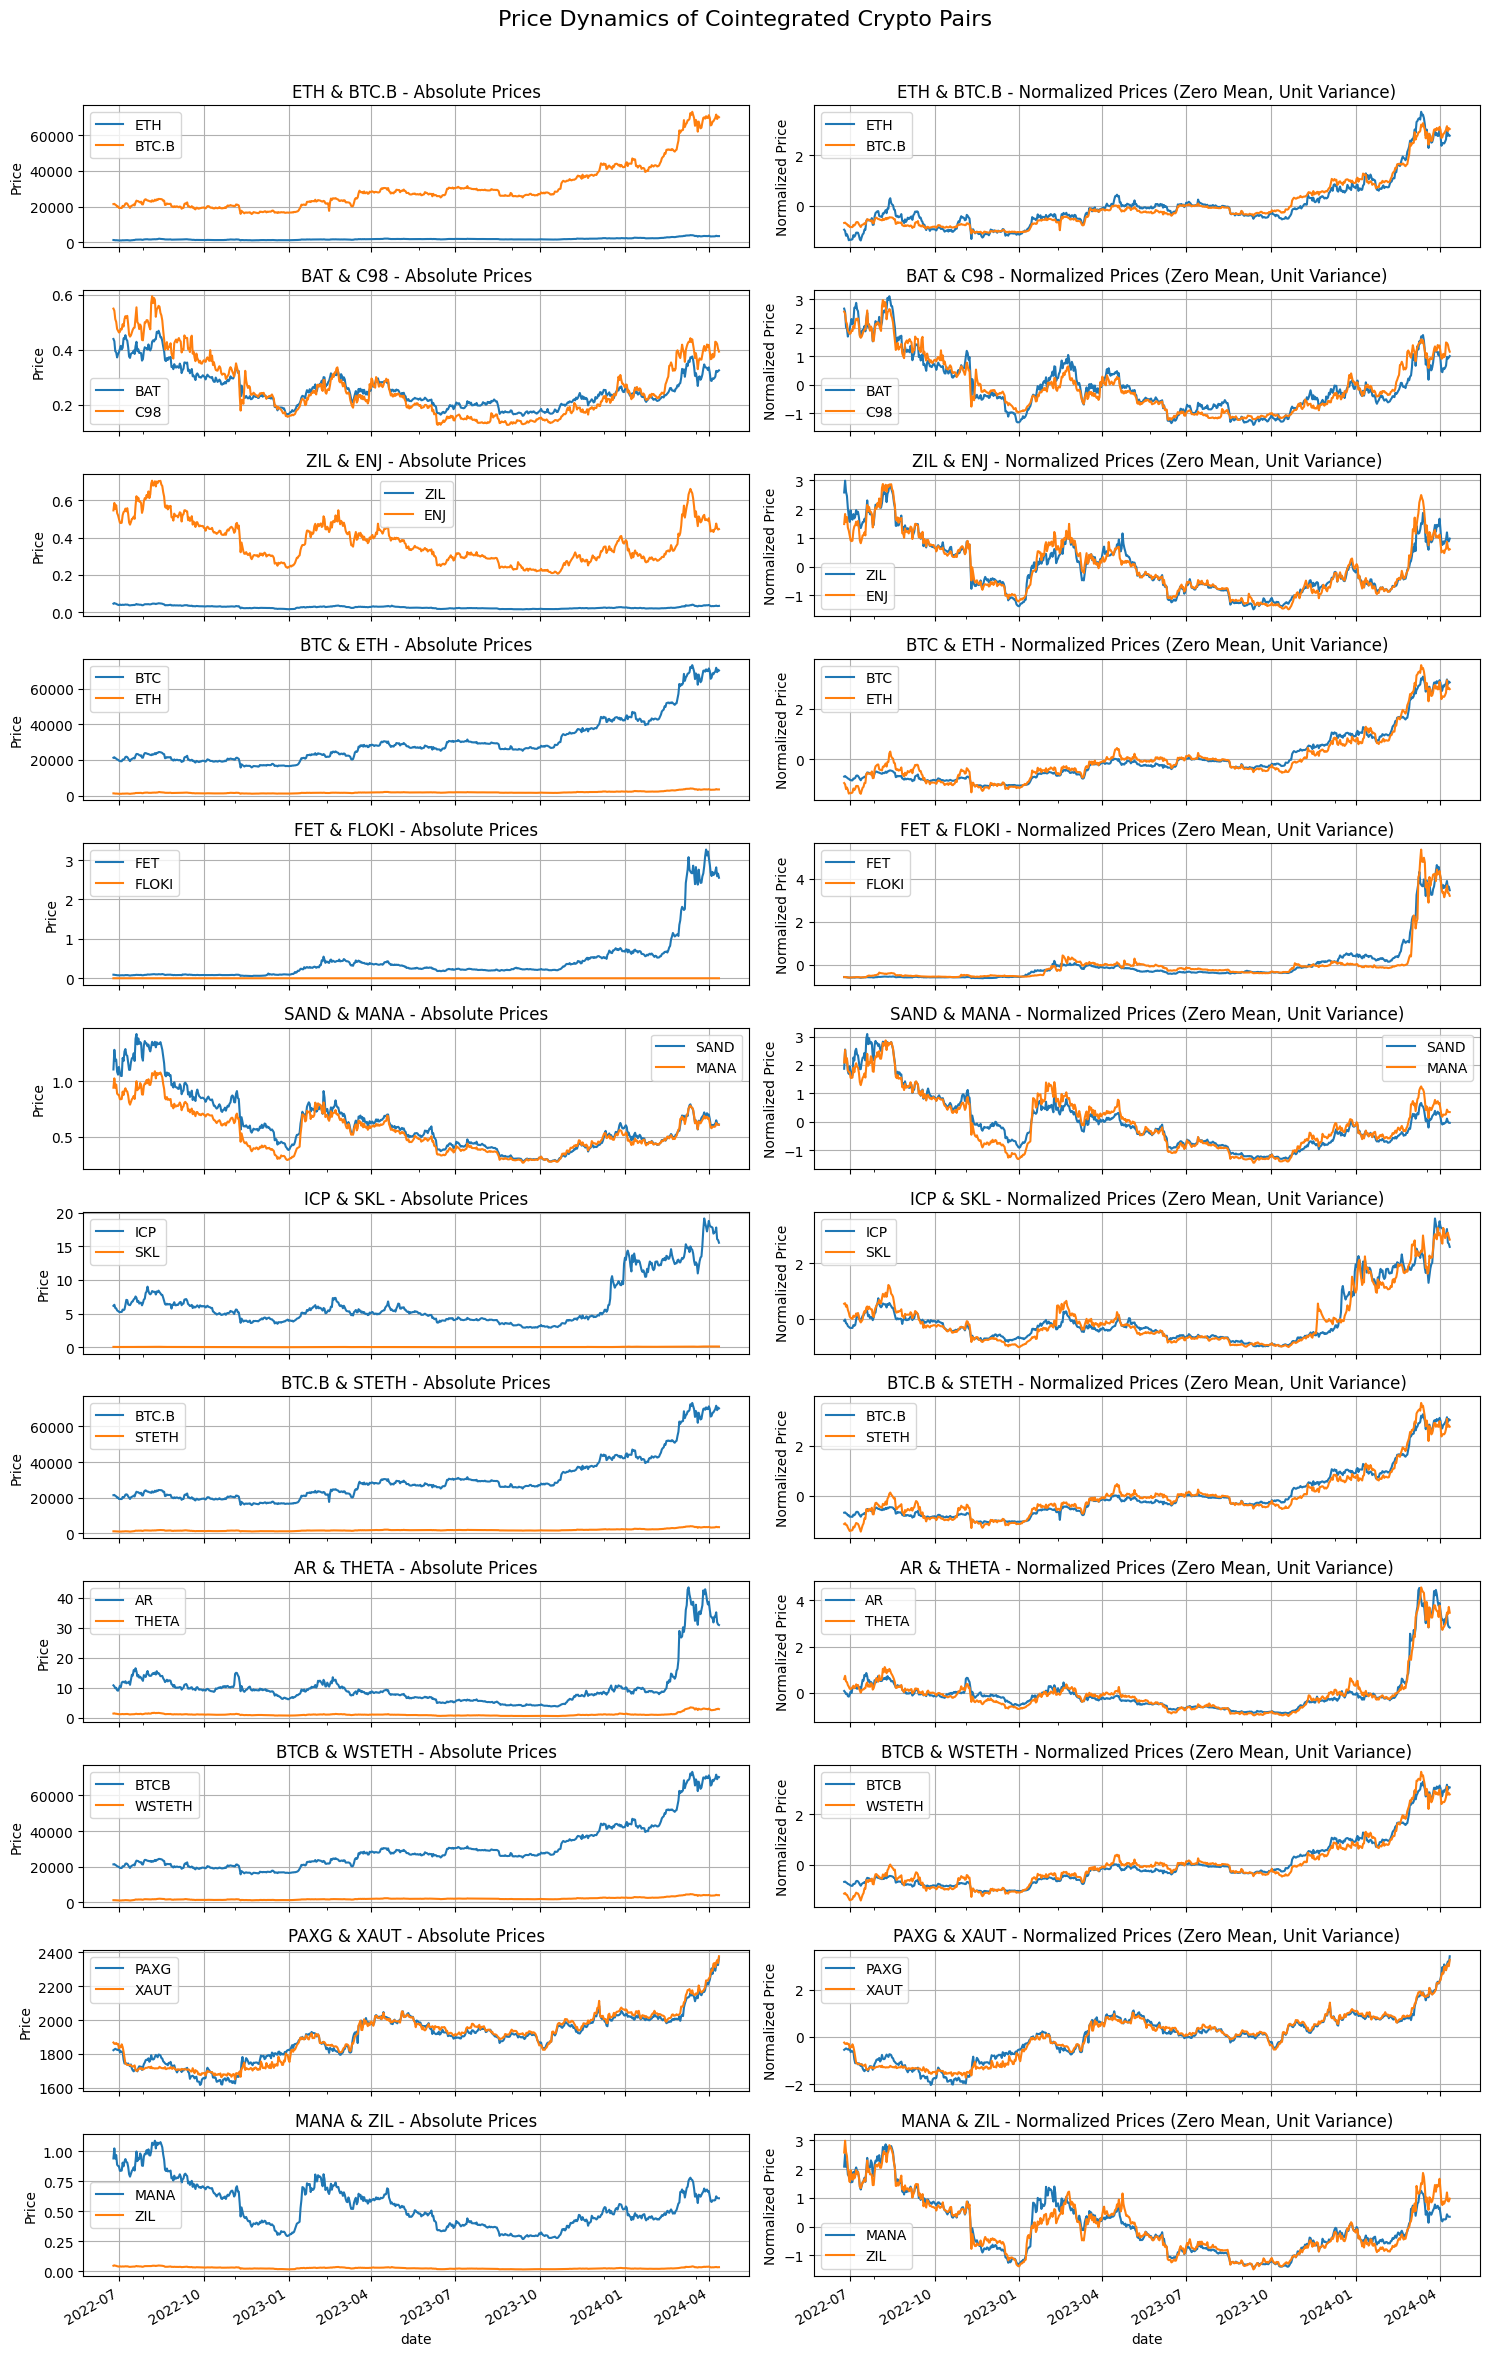

In [161]:
final_pairs = get_cointegrated_pairs(prices=train_df)

def comparison_absolute_vs_norm_prices(pair, train, train_norm, ax1, ax2):
    # Plot raw prices
    train[pair].plot(ax=ax1)
    ax1.set_title(f"{pair[0]} & {pair[1]} - Absolute Prices")
    ax1.set_ylabel("Price")
    ax1.grid(True)

    # Plot normalized prices
    train_norm[pair].plot(ax=ax2)
    ax2.set_title(f"{pair[0]} & {pair[1]} - Normalized Prices (Zero Mean, Unit Variance)")
    ax2.set_ylabel("Normalized Price")
    ax2.grid(True)

# Convert final_pairs to a list of lists (if it's a NumPy array)
final_pairs_list = final_pairs.tolist()

# Normalize prices once
train_norm = pd.DataFrame(
    StandardScaler().fit_transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

# Create a large figure with subplots
num_pairs = len(final_pairs_list)
fig, axs = plt.subplots(num_pairs, 2, figsize=(15, 2 * num_pairs), sharex=True)

for i, pair in enumerate(final_pairs_list):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    comparison_absolute_vs_norm_prices(pair, train_df, train_norm, ax1, ax2)

plt.suptitle("Price Dynamics of Cointegrated Crypto Pairs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [48]:
import pandas as pd

def split_dataset_by_ratio(price_df, train_ratio=0.6, val_ratio=0.25, test_ratio=0.15):
    """
    Splits a time-indexed DataFrame into train, validation, and test sets based on date ranges.

    Args:
        price_df (pd.DataFrame): DataFrame with datetime index.
        train_ratio (float): Portion for training (default 60%)
        val_ratio (float): Portion for validation (default 25%)
        test_ratio (float): Portion for out-of-sample testing (default 15%)

    Returns:
        train_df, val_df, test_df: Split DataFrames
    """

    # Ensure the index is datetime and sorted
    df = price_df.sort_index()
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a datetime index")

    # Calculate the total time span
    start_date = df.index.min()
    end_date = df.index.max()
    total_days = (end_date - start_date).days

    # Compute split durations
    train_days = int(total_days * train_ratio)
    val_days = int(total_days * val_ratio)

    # Compute actual split dates
    train_end = start_date + pd.Timedelta(days=train_days)
    val_end = train_end + pd.Timedelta(days=val_days)

    # Slice the DataFrame
    train_df = df.loc[:train_end]
    val_df = df.loc[train_end + pd.Timedelta(days=1):val_end]
    test_df = df.loc[val_end + pd.Timedelta(days=1):]

    # Summary print
    print(f"Date range: {start_date.date()} → {end_date.date()}  ({total_days} days)")
    print(f"Training:   {train_df.index.min().date()} → {train_df.index.max().date()} ({len(train_df)} days)")
    print(f"Validation: {val_df.index.min().date()} → {val_df.index.max().date()} ({len(val_df)} days)")
    print(f"Out-of-Sample Test: {test_df.index.min().date()} → {test_df.index.max().date()} ({len(test_df)} days)")

    return train_df, val_df, test_df

In [103]:
def ols_fit(data, coin1, coin2):
    import pandas as pd
    import statsmodels.api as sm # type: ignore
    from statsmodels.tsa.stattools import adfuller # type: ignore

    df = data[[coin1, coin2]].dropna()

    X = sm.add_constant(df[coin1])
    y = df[coin2]

    model = sm.OLS(y, X).fit()
    adf_residual_stationarity = adfuller(
        x=model.resid
    )

    results = {
        "coin1": coin1,
        "coin2": coin2,
        "alpha": model.params.iloc[0],
        "beta": model.params.iloc[1],
        "adf_test_statistic": adf_residual_stationarity[0],
        "adf_p_value": adf_residual_stationarity[1]
    }

    return pd.Series(results)

In [155]:
def get_cointegrated_pairs(prices):
    from itertools import combinations
    import re

    pairs = pd.DataFrame(
        list(
            combinations(
                iterable=prices.columns, 
                r=2
            )
        ), 
        columns=["coin1", "coin2"]
    )

    pairs["str_match"] = pairs.apply(
        lambda x: len(
            re.findall(re.escape(x['coin1']), x['coin2']) or 
            re.findall(re.escape(x['coin2']), x['coin1'])),
            axis=1
    )

    pairs = pairs.query(
        expr="str_match < 1"
    ).reset_index(
        drop=True
    ).drop(
        columns=["str_match"]
    )

    pairs["correlation"] = pairs.apply(
        lambda row: np.corrcoef(
            prices[row["coin1"]], 
            prices[row["coin2"]])[0, 1], 
            axis=1
    ).dropna()

    pairs = pairs[
        # pairs["correlation"].abs()>0.95
        pairs["correlation"]>0.96
    ].apply(
        lambda row: ols_fit(
            data=prices, 
            coin1=row['coin1'], 
            coin2=row['coin2']
            ),
            axis=1
    ).query(
        expr="adf_p_value < 0.01"
    ).reset_index(drop=True)

    pairs = pairs.loc[
        pairs.loc[
            pairs.groupby('coin1')['adf_test_statistic'].idxmax()
        ].groupby('coin2')['adf_test_statistic'].idxmax()
    ].reset_index(drop=True)

    final_pairs = pairs[["coin1", "coin2"]].values

    return final_pairs

In [160]:
def comparison_absolute_vs_norm_prices(pair, train, train_norm, ax1, ax2):
    # Plot raw prices
    train[pair].plot(ax=ax1)
    ax1.set_title(f"{pair[0]} & {pair[1]} - Absolute Prices")
    ax1.set_ylabel("Price")
    ax1.grid(True)

    # Plot normalized prices
    train_norm[pair].plot(ax=ax2)
    ax2.set_title(f"{pair[0]} & {pair[1]} - Normalized Prices (Zero Mean, Unit Variance)")
    ax2.set_ylabel("Normalized Price")
    ax2.grid(True)